In [1]:
import numpy as np
import pandas as pd
import datetime
import pytz
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,GRU,Input,LSTM,Masking
from sklearn.metrics import mean_squared_error
tf.random.set_seed(42)
n_rnn = 1
n_dense = 21
period_length = 3
import logging
logging.basicConfig(level=logging.INFO)

2024-08-25 13:14:00.619337: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-25 13:14:01.391073: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 13:14:04.908554: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 13:14:04.921533: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-25 13:14:36.799747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [52]:
def rho_w(T):#density of water kg/m3 at T deg C
    #10.1088/0026-1394/38/4/3
    a = [-3.983035,301.797,522528.9,69.34881,999.97495]
    return a[4]*(1-(T+a[0])**2*(T+a[1])/a[2]/(T+a[3]))
def latent(T):#latent heat of vaporization kJ/kg at T deg C
    return 2501 - 0002.361 * T
def vpd(rh,t):
    #tetens
    es = esa(t)
    return es *(1- rh / 100)

def esa(T):#saturation vapor pressure kPa, T is temp in deg C
    return  0.61078 * np.exp((17.269 * T) / (237.3 + T))
    return

In [3]:
cook_flux = pd.read_csv('../../raw/CookIRCamET/Meteorological/Cook/EcTower/REddyProc/CookEast/6503_20240805_REP_output.csv',skiprows=[1,2],sep='\t').replace(to_replace=-9999,value=np.nan)

In [4]:
cook_hy2023_v1 = pd.read_csv('../../work/CookIRCamET/Working/cookhy2023_V1_output.csv')
cook_hy2023_v2 = pd.read_csv('../../work/CookIRCamET/Working/cookhy2023_V2_output.csv')
cook_hy2024_v3 = pd.read_csv('../../work/CookIRCamET/Working/cookhy2024_V3_output.csv')

In [5]:
cook_hy2024_v3

,Unnamed: 0,times,daylight,elevation,azimuth,fssun,fsshd,frsun,frshd,fvsun,...,fwsun,fwshd,Tssun,Tsshd,Trsun,Trshd,Tvsun,Tvshd,Twsun,Twshd
0,0,2023-09-08 20:19:11+00:00,True,41.835873,192.456858,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2023-09-08 21:19:12+00:00,True,45.861737,213.292897,0.036930,0.327970,0.309700,0.324927,0.000357,...,0.000000e+00,0.000000,312.354712,311.925692,312.586153,312.408882,312.829274,310.814855,NaN,NaN
2,2,2023-09-08 22:19:12+00:00,True,52.763931,230.812548,0.041342,0.413425,0.284603,0.259951,0.000588,...,3.616898e-07,0.000000,315.246759,314.427798,315.342695,314.939764,315.233121,313.790427,314.036142,NaN
3,3,2023-09-08 23:19:13+00:00,True,61.485658,245.284345,0.066107,0.472266,0.298850,0.161653,0.001085,...,0.000000e+00,0.000000,310.112468,309.565353,310.188566,309.791437,309.945436,308.386400,NaN,NaN
4,4,2023-09-09 00:19:14+00:00,True,71.213228,257.668459,0.138928,0.514725,0.274731,0.069238,0.002352,...,3.255208e-06,0.000000,307.559260,307.211724,307.714868,307.333393,307.770200,307.520617,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4421,4421,2024-07-10 12:09:18+00:00,False,89.757213,56.278251,0.000000,0.494015,0.000000,0.097044,0.000000,...,0.000000e+00,0.000414,NaN,296.370037,NaN,296.361676,NaN,296.488238,NaN,296.109100
4422,4422,2024-07-10 13:09:21+00:00,False,81.145755,66.887210,0.000000,0.494015,0.000000,0.097044,0.000000,...,0.000000e+00,0.000414,NaN,296.858950,NaN,296.853875,NaN,296.898624,NaN,296.657049
4423,4423,2024-07-10 14:09:26+00:00,True,71.432031,77.093499,0.049701,0.460120,0.009362,0.005704,0.204615,...,5.425347e-06,0.000000,299.430503,299.419797,299.480492,299.425984,299.455335,299.423092,299.135410,NaN
4424,4424,2024-07-10 15:09:31+00:00,True,61.277254,87.468228,0.108737,0.319422,0.015329,0.005319,0.272854,...,1.450376e-04,0.000000,302.450501,302.446421,302.466497,302.498473,302.432272,302.385444,302.560513,NaN


In [6]:
cook_hy2023_v1['times'] = pd.to_datetime(cook_hy2023_v1.times)
cook_hy2023_v2['times'] = pd.to_datetime(cook_hy2023_v2.times)
cook_hy2024_v3['times'] = pd.to_datetime(cook_hy2024_v3.times)

In [7]:
cook_hys = pd.concat([cook_hy2023_v1,cook_hy2023_v2,cook_hy2024_v3]).reset_index()

In [8]:
cook_flux.keys()

Index(['Year', 'DoY', 'Hour', 'NEE', 'LE', 'H', 'Rg', 'Tair', 'Tsoil', 'rH',
       'VPD', 'Ustar', 'season', 'Ustar_uStar_Thres', 'Ustar_uStar_fqc',
       'LE_uStar_orig', 'LE_uStar_f', 'LE_uStar_fqc', 'LE_uStar_fall',
       'LE_uStar_fall_qc', 'LE_uStar_fnum', 'LE_uStar_fsd', 'LE_uStar_fmeth',
       'LE_uStar_fwin', 'Ustar_U05_Thres', 'Ustar_U05_fqc', 'LE_U05_orig',
       'LE_U05_f', 'LE_U05_fqc', 'LE_U05_fall', 'LE_U05_fall_qc',
       'LE_U05_fnum', 'LE_U05_fsd', 'LE_U05_fmeth', 'LE_U05_fwin',
       'Ustar_U50_Thres', 'Ustar_U50_fqc', 'LE_U50_orig', 'LE_U50_f',
       'LE_U50_fqc', 'LE_U50_fall', 'LE_U50_fall_qc', 'LE_U50_fnum',
       'LE_U50_fsd', 'LE_U50_fmeth', 'LE_U50_fwin', 'Ustar_U95_Thres',
       'Ustar_U95_fqc', 'LE_U95_orig', 'LE_U95_f', 'LE_U95_fqc', 'LE_U95_fall',
       'LE_U95_fall_qc', 'LE_U95_fnum', 'LE_U95_fsd', 'LE_U95_fmeth',
       'LE_U95_fwin', 'Tair_orig', 'Tair_f', 'Tair_fqc', 'Tair_fall',
       'Tair_fall_qc', 'Tair_fnum', 'Tair_fsd', 'Tair_fmeth', '

In [9]:
cook_flux = cook_flux[['Year', 'DoY', 'Hour', 'Rg', 'Tair', 'rH', 'VPD', 'LE_uStar_f']]
cook_flux['lambda']=cook_flux.Tair.apply(latent)
cook_flux['rho_w']=cook_flux.Tair.apply(rho_w)

In [10]:
cook_flux['ET']=cook_flux['LE_uStar_f']/cook_flux['lambda']/cook_flux['rho_w']*60*30#mm H20 in 30min
cook_flux['Minutes']=60*(cook_flux['Hour']-np.floor(cook_flux['Hour']))

In [11]:
cook_flux['Hour']=np.floor(cook_flux['Hour'])

In [12]:
cook_flux = cook_flux[['Year', 'DoY', 'Hour', 'Minutes', 'Rg', 'Tair', 'rH', 'VPD','ET']]

In [13]:
cook_flux['times']=pd.to_datetime(cook_flux['Year'].astype(str) + ' ' + cook_flux['DoY'].astype(str) + ' ' + cook_flux['Hour'].astype(int).astype(str)+':'+cook_flux['Minutes'].astype(int).astype(str),
    format='%Y %j %H:%M'
   )

In [14]:
#half-hourly to hourly
cook_flux=cook_flux.groupby(['Year','DoY','Hour']).agg({'times':'max', 'Rg':'mean', 'Tair':'mean', 'rH':'mean', 'VPD':'mean', 'ET':'sum'}).reset_index()

In [15]:
cook_flux['times'] = cook_flux.times.dt.tz_localize('Etc/GMT+8')

In [16]:
cook_flux['times'] = cook_flux.times.dt.tz_convert('UTC')

In [17]:
#should check tz's match

In [18]:
cook_flux.Tair+=273.15

<Axes: xlabel='times'>

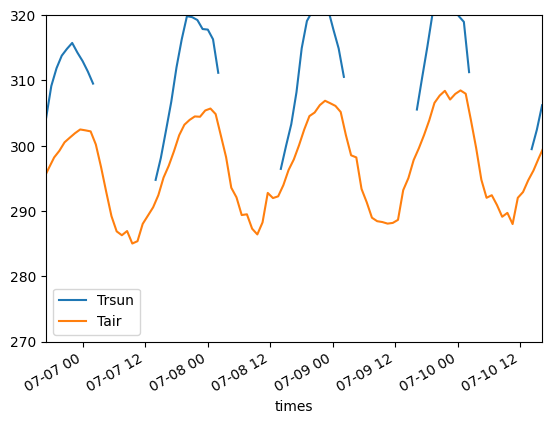

In [19]:
ax = cook_hys.plot(x='times',y='Trsun',
                 xlim = [cook_hys.times.values[-96],cook_hys.times.values[-1]],ylim=[270,320])

cook_flux.plot(x='times',y='Tair',
                 xlim = [cook_hys.times.values[-96],cook_hys.times.values[-1]],ylim=[270,320],ax=ax)

In [20]:
xlim=[pd.to_datetime('2024-01-01 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2024-07-10 00:00:00',format='%Y-%m-%d %H:%M:%S')]

<Axes: xlabel='times'>

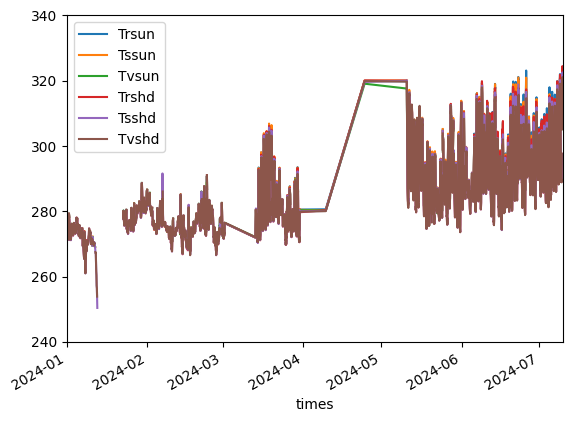

In [21]:
cook_hys.plot(x='times',y=['Trsun','Tssun','Tvsun','Trshd','Tsshd','Tvshd'],xlim=xlim,ylim=[240,340])

<Axes: xlabel='times'>

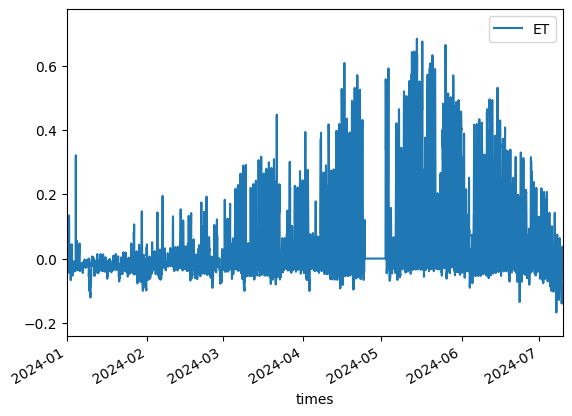

In [22]:
cook_flux.plot(x='times',y=['ET'],xlim=xlim)

In [23]:
cook_hys['times2']=cook_hys['times']
for i in cook_hys.index:
    mask = abs(cook_hys.loc[i,'times']-cook_flux['times'])==min(abs(cook_hys.loc[i,'times']-cook_flux['times']))
    cook_hys.loc[i,'times2'] = cook_flux.loc[mask,'times'].values[0]

In [24]:
cook_hys = cook_hys.drop(columns=['times'])

In [25]:
cook_hys = cook_hys.rename(columns={'times2':'times'}).drop(columns=['index', 'Unnamed: 0'])

In [26]:
cook_hys['times'] = cook_hys.astype({'times':'datetime64[ns]'}).reset_index().times.dt.tz_localize('UTC')

In [27]:
cook_flux = cook_flux.merge(cook_hys,how='left')
cook_flux=cook_flux[cook_flux.times>=cook_hys.times.min()]
cook_flux=cook_flux[cook_flux.times<=cook_hys.times.max()]

In [28]:
inputs = ['elevation', 'azimuth', 'fssun',
       'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd', 'fwsun', 'fwshd', 'Tssun',
       'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd', 'Twsun', 'Twshd']
outputs = ['ET']

In [29]:
for i in inputs:
    if 'T' in i:
        cook_flux.loc[cook_flux[i]<250,i]=np.nan

In [30]:
bad_ir = cook_flux.apply(lambda p: np.all(np.isnan(p[['Tsshd', 'Trshd', 'Tvshd', 'Twshd']].astype('float64').values)),axis=1)

In [31]:
cook_flux['BadIR']=bad_ir

In [32]:
cook_flux['Hour']=cook_flux.times.dt.hour

In [33]:
cook_flux = cook_flux.groupby('times').aggregate('mean').reset_index()

In [34]:
cook_flux.to_csv('../../work/CookIRCamET/Working/cook_hys_ec.csv',index=False)

In [35]:
cook_flux = pd.read_csv('../../work/CookIRCamET/Working/cook_hys_ec.csv')

In [36]:
cook_flux_interp = cook_flux.copy().drop_duplicates().sort_values('times')

In [37]:
end_idx = cook_flux_interp[cook_flux_interp.times=='2023-03-22 03:30:00+00:00'].index[0]
start_idx = cook_flux_interp[cook_flux_interp.times=='2023-05-22 17:30:00+00:00'].index[0]
#make chunks around gap
cook_flux_chunk1 = cook_flux_interp.loc[0:end_idx+1,:]
cook_flux_chunk2 = cook_flux_interp.loc[start_idx:,:]

In [38]:
gb1 = cook_flux_chunk1.groupby(['Year','DoY'])

In [39]:
flux_days1 = [gb1.get_group(g).sort_values('times') for g in gb1.groups if len(gb1.get_group(g))==24]

In [40]:
gb2 = cook_flux_chunk2.groupby(['Year','DoY'])

In [41]:
flux_days2 = [gb2.get_group(g).sort_values('times') for g in gb2.groups if len(gb2.get_group(g))==24]

In [42]:
daily_flux = pd.concat([*flux_days1,*flux_days2])[['times','ET', 'Rg', 'Tair', 'rH','VPD', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd','BadIR']].reset_index().drop(columns='index')

In [43]:
inputs = ['Rg', 'Tair', 'rH', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd'] 

In [44]:
n_feats = len(inputs)

In [45]:
#replace nans with maskable value
daily_flux.replace(to_replace=np.nan,value=0,inplace=True)

In [46]:
#return bad measurements with nan
daily_flux.loc[daily_flux.BadIR==True,['Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd','Twsun', 'Twshd']]=np.nan

In [47]:
#interpolate nan
for i in inputs:
    if 'T' in i:
        daily_flux.loc[:,i]=daily_flux[i].interpolate(method='linear')

In [48]:
daily_flux.to_csv('../../work/CookIRCamET/Working/cookhy2023_batches_processed.csv', index=False)

In [49]:
daily_flux

,times,ET,Rg,Tair,rH,VPD,elevation,azimuth,fssun,fsshd,...,fwshd,Tssun,Tsshd,Trsun,Trshd,Tvsun,Tvshd,Twsun,Twshd,BadIR
0,2022-10-29 08:30:00+00:00,-0.033872,0.006553,280.70975,61.244940,4.05595,144.502093,24.274670,0.0,0.290174,...,0.000000,0.0,279.626880,0.0,279.577572,0.0,279.469706,0.0,0.000000,0.0
1,2022-10-29 09:30:00+00:00,-0.034795,0.014894,280.31980,63.375175,3.72745,138.590146,45.928182,0.0,0.290174,...,0.000000,0.0,279.019233,0.0,278.987619,0.0,278.880171,0.0,0.000000,0.0
2,2022-10-29 10:30:00+00:00,-0.045252,0.015133,279.88445,62.752740,3.67880,130.242746,62.861721,0.0,0.290174,...,0.000000,0.0,278.511946,0.0,278.501961,0.0,278.394037,0.0,0.000000,0.0
3,2022-10-29 11:30:00+00:00,-0.036482,0.034794,280.31530,59.772385,4.09250,120.618555,76.457302,0.0,0.290174,...,0.000000,0.0,279.278025,0.0,279.273968,0.0,279.144232,0.0,0.000000,0.0
4,2022-10-29 12:30:00+00:00,-0.031992,0.019780,280.10170,61.189055,3.89175,110.447587,88.150103,0.0,0.290174,...,0.000000,0.0,279.213961,0.0,279.212948,0.0,279.084689,0.0,0.000000,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13363,2024-07-10 03:30:00+00:00,-0.042327,33.847500,299.66900,39.886290,21.15400,85.740030,298.475565,0.0,0.494015,...,0.000414,0.0,304.161451,0.0,304.173994,0.0,304.026249,0.0,304.168537,0.0
13364,2024-07-10 04:30:00+00:00,-0.070295,0.926107,294.80450,50.129135,13.32995,94.452174,309.465677,0.0,0.494015,...,0.000414,0.0,300.205113,0.0,300.209014,0.0,300.098069,0.0,300.226401,0.0
13365,2024-07-10 05:30:00+00:00,-0.094343,0.000000,292.02900,53.725890,10.19265,101.664849,321.469861,0.0,0.494015,...,0.000414,0.0,294.544862,0.0,294.564068,0.0,294.404622,0.0,294.616749,0.0
13366,2024-07-10 06:30:00+00:00,-0.088284,0.001666,292.42250,46.613880,12.06750,107.109080,334.676575,0.0,0.494015,...,0.000414,0.0,294.034980,0.0,294.050427,0.0,293.913028,0.0,294.013189,0.0


In [ ]:
cprl_met_vars = ['NE_Year','NE_DOY','NE_Time in hhmm','NE_Rs in W/m^2','NE_air temp in degrees C','NE_RH in %']
cprl_lys_vars = ['Year','DOY','Tdec','ET (mm)']

cprl_met = pd.read_csv("../../raw/CookIRCamET/Meteorological/Cprl/NE_lys_2023_for_Joaquin/2023_NE_Cotton_Lys_ClimDat_New_15_min.csv")[cprl_met_vars]

In [53]:
cprl_met['VPD'] =10*cprl_met.apply(lambda x: vpd(x['NE_air temp in degrees C'],x['NE_RH in %']),axis=1)#hpa
cprl_lys = pd.read_csv("../../raw/CookIRCamET/Meteorological/Cprl/NE_lys_updated_2023/2023_NE_Cotton_water_balance_15_min_matlab.csv")[cprl_lys_vars]

In [54]:
cprl_hy2023_v1 = pd.read_csv('../../work/CookIRCamET/Working/cprlhy2023_V1_output.csv')
cprl_hy2023_v2 = pd.read_csv('../../work/CookIRCamET/Working/cprlhy2023_V2_output.csv')
cprl_hy2023 = pd.concat([cprl_hy2023_v1,cprl_hy2023_v2]).reset_index()#.astype({'times':'datetime64'})

In [55]:
cprl_hy2023.times

0       2023-04-11 19:21:31+00:00
1       2023-04-11 19:51:36+00:00
2       2023-04-11 20:21:42+00:00
3       2023-04-11 20:51:47+00:00
4       2023-04-11 21:21:53+00:00
                  ...            
4965    2023-10-13 12:39:27+00:00
4966    2023-10-13 13:39:32+00:00
4967    2023-10-13 14:39:38+00:00
4968    2023-10-13 15:39:44+00:00
4969    2023-10-13 16:39:50+00:00
Name: times, Length: 4970, dtype: object

In [56]:
cprl_hy2023['times'] = pd.to_datetime(cprl_hy2023.times)#.dt.tz_localize('UTC')
cprl_hy2023 = cprl_hy2023[['times', 'daylight', 'elevation', 'azimuth',
       'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd', 'fwsun', 'fwshd',
       'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd', 'Twsun', 'Twshd']]

In [57]:
cprl_met = cprl_met.rename(columns={'NE_Year':'Year','NE_DOY':'DoY','NE_Time in hhmm':'HHMM','NE_Rs in W/m^2':'Rg','NE_air temp in degrees C':'Tair','NE_RH in %':'rH'})

In [58]:
cprl_lys = cprl_lys.rename(columns={'DOY':'DoY','Tdec':'Hour','ET (mm)':'ET'})

In [59]:
cprl_lys['Minutes']=60*(cprl_lys['Hour']-np.floor(cprl_lys['Hour']))
cprl_lys['Minutes']=cprl_lys['Minutes'].astype(int).astype(str)
cprl_lys['Hour']=np.floor(cprl_lys['Hour']).astype(int).astype(str)

In [60]:
mask = cprl_lys.Hour=='24'
cprl_lys.loc[mask,'Hour']='0'
cprl_lys.loc[mask,'DoY']=cprl_lys.loc[mask,'DoY']+1

In [61]:
mask = cprl_lys.DoY==366
cprl_lys.loc[mask,'DoY']=1
cprl_lys.loc[mask,'Year']=2024

In [62]:
cprl_met['Hour'] = np.floor(cprl_met.HHMM/100).astype(int).astype(str)
cprl_met['Minutes'] = 100*(cprl_met.HHMM/100 - np.floor(cprl_met.HHMM/100))
cprl_met['Minutes'] = cprl_met.Minutes.astype(int).astype(str)
cprl_met['Minutes']=cprl_met.Minutes.replace({'14':'15','44':'45'})

In [63]:
mask = cprl_met.Hour=='24'
cprl_met.loc[mask,'Hour']='0'
cprl_met.loc[mask,'DoY']=cprl_met.loc[mask,'DoY']+1

In [64]:
mask = cprl_met.DoY==366
cprl_met.loc[mask,'DoY']=1
cprl_met.loc[mask,'Year']=2024

In [65]:
cprl_met_lys=cprl_lys.merge(cprl_met,on=['Hour','Minutes','Year','DoY'],how='left')

In [66]:
cprl_met_lys=cprl_met_lys.groupby(['Year','DoY','Hour']).agg({'Rg':'mean', 'Tair':'mean', 'rH':'mean', 'ET':'sum','VPD':'mean'}).reset_index(drop=False)

In [67]:
cprl_met_lys['times']=pd.to_datetime(cprl_met_lys['Year'].astype(str) + ' ' + cprl_met_lys['DoY'].astype(str) + ' ' + cprl_met_lys['Hour']+':'+'00',
    format='%Y %j %H:%M'
   )

In [68]:
cprl_met_lys.Tair+=273.15

In [69]:
cprl_met_lys

,Year,DoY,Hour,Rg,Tair,rH,ET,VPD,times
0,2023,1,0,NaN,NaN,NaN,0.065940,NaN,2023-01-01 00:00:00
1,2023,1,1,NaN,NaN,NaN,-0.142809,NaN,2023-01-01 01:00:00
2,2023,1,10,NaN,NaN,NaN,0.040944,NaN,2023-01-01 10:00:00
3,2023,1,11,NaN,NaN,NaN,0.128769,NaN,2023-01-01 11:00:00
4,2023,1,12,NaN,NaN,NaN,0.097980,NaN,2023-01-01 12:00:00
...,...,...,...,...,...,...,...,...,...
8756,2023,365,6,NaN,NaN,NaN,0.000000,NaN,2023-12-31 06:00:00
8757,2023,365,7,NaN,NaN,NaN,0.000000,NaN,2023-12-31 07:00:00
8758,2023,365,8,NaN,NaN,NaN,0.000000,NaN,2023-12-31 08:00:00
8759,2023,365,9,NaN,NaN,NaN,0.000000,NaN,2023-12-31 09:00:00


In [70]:
cprl_met_lys['times'] = cprl_met_lys.times.dt.tz_localize('Etc/GMT+6')

In [71]:
cprl_met_lys['times'] = cprl_met_lys.times.dt.tz_convert('UTC')

In [72]:
cprl_hy2023['times2']=cprl_hy2023['times']
for i in cprl_hy2023.index:
    mask = abs(cprl_hy2023.loc[i,'times']-cprl_met_lys['times'])==min(abs(cprl_hy2023.loc[i,'times']-cprl_met_lys['times']))
    cprl_hy2023.loc[i,'times2'] = cprl_met_lys.loc[mask,'times'].values[0]

In [73]:
cprl_hy2023 = cprl_hy2023.drop(columns=['times']).rename(columns={'times2':'times'})

In [74]:
cprl_hy2023 = cprl_hy2023.astype({'times':'datetime64[ns]'}).reset_index(drop=True)

In [75]:
cprl_hy2023['times'] = cprl_hy2023.times.dt.tz_localize('UTC')

In [76]:
cprl_hy2023 = cprl_hy2023.groupby(['times']).agg({'daylight':'mean', 'elevation':'mean', 'azimuth':'mean',
       'fssun':'mean', 'fsshd':'mean', 'frsun':'mean', 'frshd':'mean', 'fvsun':'mean', 'fvshd':'mean', 'fwsun':'mean', 'fwshd':'mean',
       'Tssun':'mean', 'Tsshd':'mean', 'Trsun':'mean', 'Trshd':'mean', 'Tvsun':'mean', 'Tvshd':'mean', 'Twsun':'mean', 'Twshd':'mean'}).reset_index(drop=False) 

In [77]:
cprl_flux = cprl_met_lys.merge(cprl_hy2023,how='left',on = 'times')

In [78]:
cprl_flux

,Year,DoY,Hour,Rg,Tair,rH,ET,VPD,times,daylight,...,fwsun,fwshd,Tssun,Tsshd,Trsun,Trshd,Tvsun,Tvshd,Twsun,Twshd
0,2023,1,0,NaN,NaN,NaN,0.065940,NaN,2023-01-01 06:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023,1,1,NaN,NaN,NaN,-0.142809,NaN,2023-01-01 07:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023,1,10,NaN,NaN,NaN,0.040944,NaN,2023-01-01 16:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023,1,11,NaN,NaN,NaN,0.128769,NaN,2023-01-01 17:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023,1,12,NaN,NaN,NaN,0.097980,NaN,2023-01-01 18:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,2023,365,6,NaN,NaN,NaN,0.000000,NaN,2023-12-31 12:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8757,2023,365,7,NaN,NaN,NaN,0.000000,NaN,2023-12-31 13:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8758,2023,365,8,NaN,NaN,NaN,0.000000,NaN,2023-12-31 14:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8759,2023,365,9,NaN,NaN,NaN,0.000000,NaN,2023-12-31 15:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='times'>

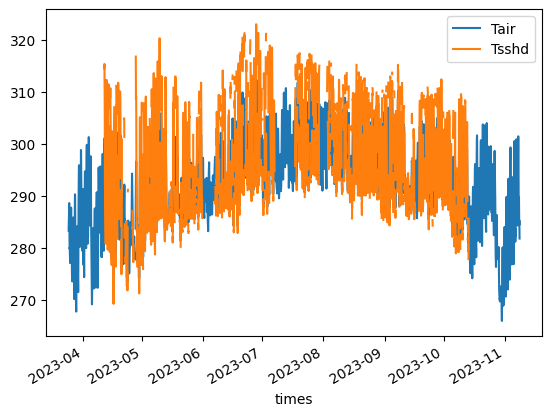

In [79]:
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y='Tsshd',ax=ax)

In [80]:
#timezone check & "good chunks"
xlim_list = []

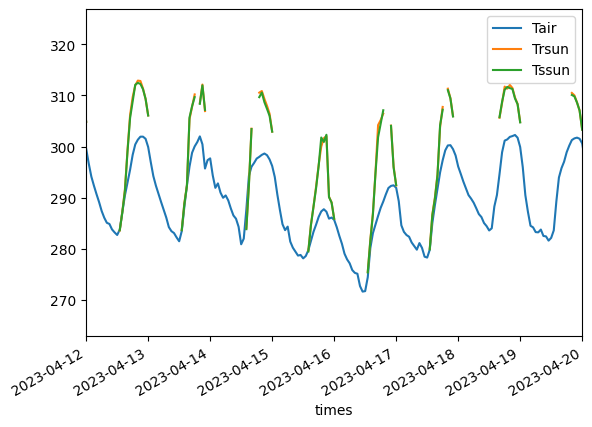

In [81]:
xlim=[pd.to_datetime('2023-04-12 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-04-20 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

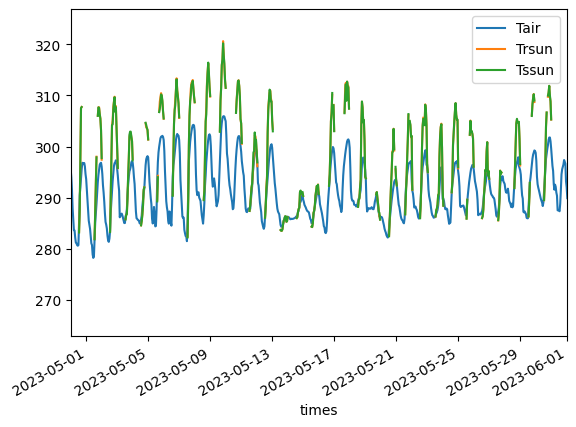

In [82]:
xlim=[pd.to_datetime('2023-04-30 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-06-01 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_met_lys.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

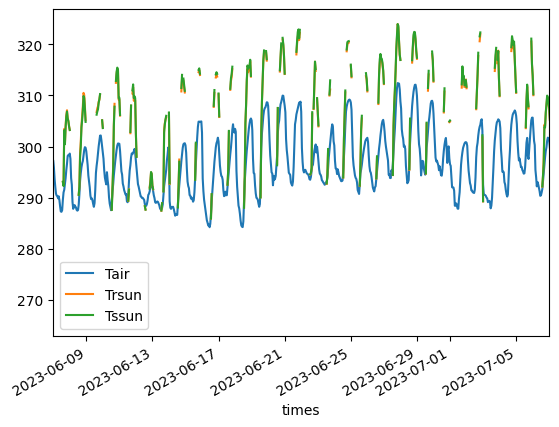

In [83]:
xlim=[pd.to_datetime('2023-06-07 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-07-07 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

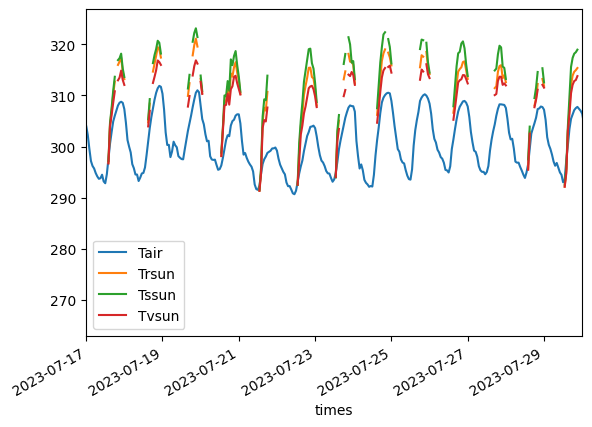

In [84]:
xlim=[pd.to_datetime('2023-07-17 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-07-30 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun','Tvsun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

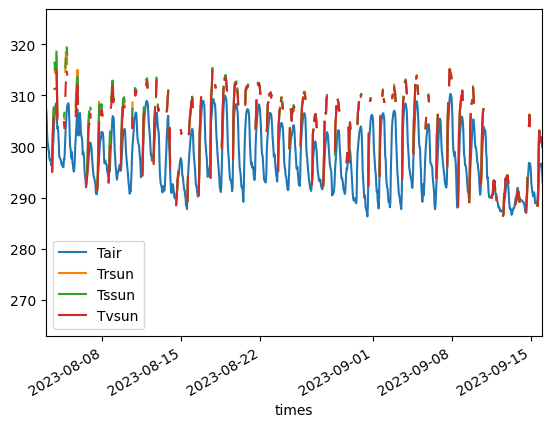

In [85]:
xlim=[pd.to_datetime('2023-08-03 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-09-16 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun','Tvsun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

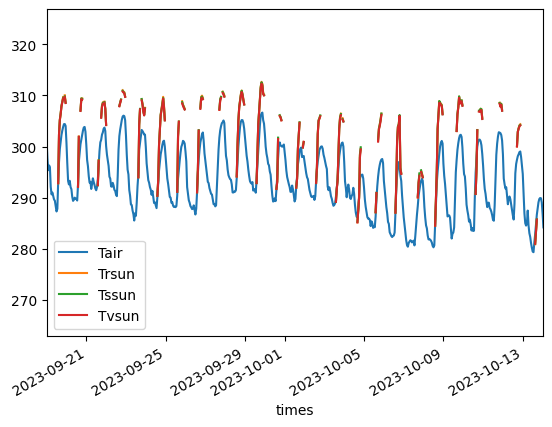

In [86]:
xlim=[pd.to_datetime('2023-09-19 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-10-14 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun','Tvsun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

In [87]:
for i in inputs:
    if 'T' in i:
        cprl_flux.loc[cprl_flux[i]<250,i]=np.nan

In [88]:
bad_ir = cprl_flux.apply(lambda p: np.all(np.isnan(p[['Tsshd', 'Trshd', 'Tvshd', 'Twshd']].astype('float64').values)),axis=1)

In [89]:
cprl_flux['BadIR']=bad_ir

In [90]:
cprl_flux

,Year,DoY,Hour,Rg,Tair,rH,ET,VPD,times,daylight,...,fwshd,Tssun,Tsshd,Trsun,Trshd,Tvsun,Tvshd,Twsun,Twshd,BadIR
0,2023,1,0,NaN,NaN,NaN,0.065940,NaN,2023-01-01 06:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,2023,1,1,NaN,NaN,NaN,-0.142809,NaN,2023-01-01 07:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,2023,1,10,NaN,NaN,NaN,0.040944,NaN,2023-01-01 16:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,2023,1,11,NaN,NaN,NaN,0.128769,NaN,2023-01-01 17:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,2023,1,12,NaN,NaN,NaN,0.097980,NaN,2023-01-01 18:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,2023,365,6,NaN,NaN,NaN,0.000000,NaN,2023-12-31 12:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
8757,2023,365,7,NaN,NaN,NaN,0.000000,NaN,2023-12-31 13:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
8758,2023,365,8,NaN,NaN,NaN,0.000000,NaN,2023-12-31 14:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
8759,2023,365,9,NaN,NaN,NaN,0.000000,NaN,2023-12-31 15:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [91]:
cprl_flux = cprl_flux.sort_values('times').reset_index(drop=True)

In [92]:
chunks = []
gbs = []
fds = []

In [93]:
for xlim in xlim_list:
    print(xlim)
    start_idx = cprl_flux[cprl_flux.times==xlim[0].tz_localize('UTC')].index[0]
    end_idx = cprl_flux[cprl_flux.times==xlim[1].tz_localize('UTC')].index[0]
    print(start_idx,end_idx)
    #make chunks
    cprl_flux_chunks=cprl_flux.loc[start_idx:end_idx+1,:]
    chunks.append(cprl_flux_chunks)
    gb=cprl_flux_chunks.groupby(['Year','DoY'])
    gbs.append(gb)
    fds.append([gb.get_group(g).sort_values('times') for g in gb.groups if len(gb.get_group(g))==24])

[Timestamp('2023-04-12 00:00:00'), Timestamp('2023-04-20 00:00:00')]
2418 2610
[Timestamp('2023-04-30 00:00:00'), Timestamp('2023-06-01 00:00:00')]
2850 3618
[Timestamp('2023-06-07 00:00:00'), Timestamp('2023-07-07 00:00:00')]
3762 4482
[Timestamp('2023-07-17 00:00:00'), Timestamp('2023-07-30 00:00:00')]
4722 5034
[Timestamp('2023-08-03 00:00:00'), Timestamp('2023-09-16 00:00:00')]
5130 6186
[Timestamp('2023-09-19 00:00:00'), Timestamp('2023-10-14 00:00:00')]
6258 6858


In [94]:
fds = [f
       for fd in fds
       for f in fd ]

In [95]:
daily_flux = pd.concat(fds).reset_index(drop=True)

In [96]:
daily_flux = daily_flux[['times','ET', 'Rg', 'Tair', 'rH','VPD', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd','BadIR']]

In [97]:
inputs = ['Rg', 'Tair', 'rH','VPD', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd'] 

In [98]:

n_feats = len(inputs)

In [99]:
#replace nans with maskable value
daily_flux.replace(to_replace=np.nan,value=0,inplace=True)

In [100]:
#return bad measurements with nan
daily_flux.loc[daily_flux.BadIR==True,['Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd','Twsun', 'Twshd']]=np.nan

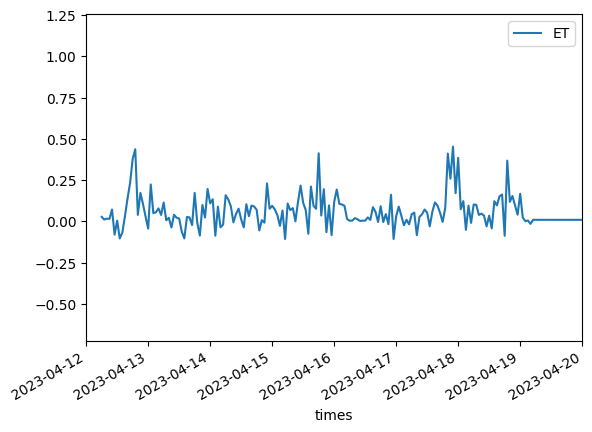

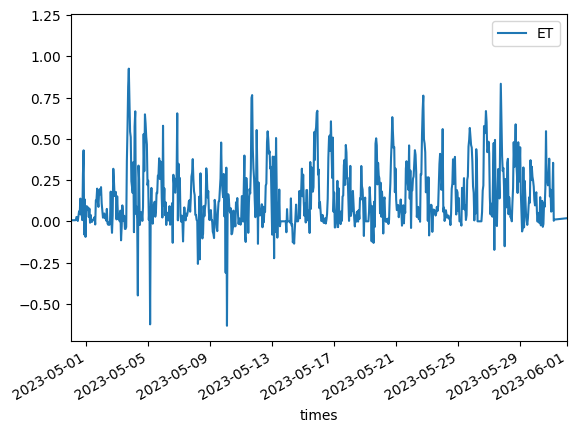

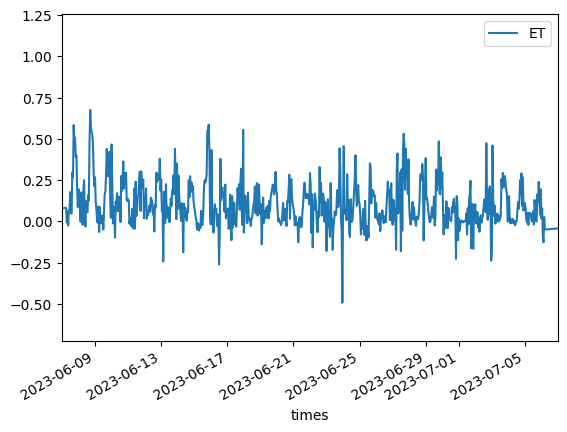

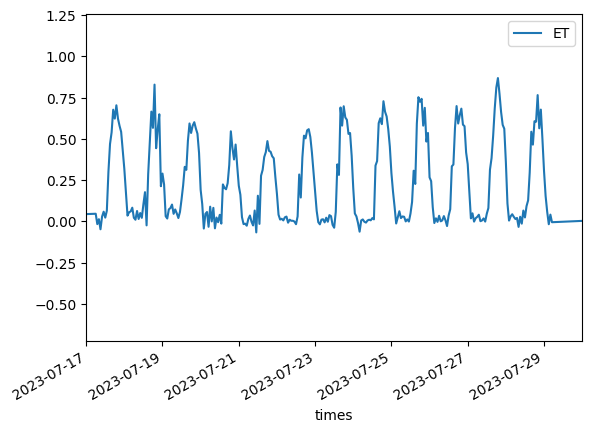

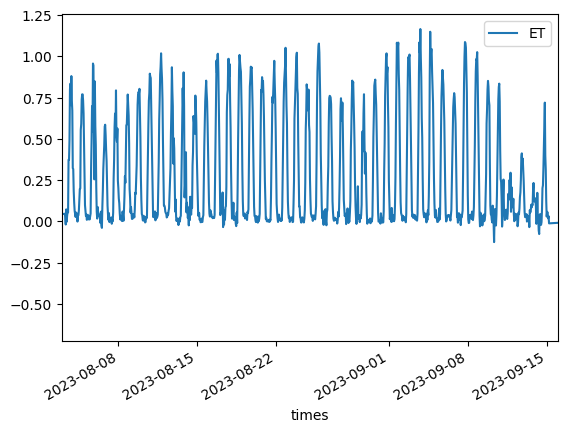

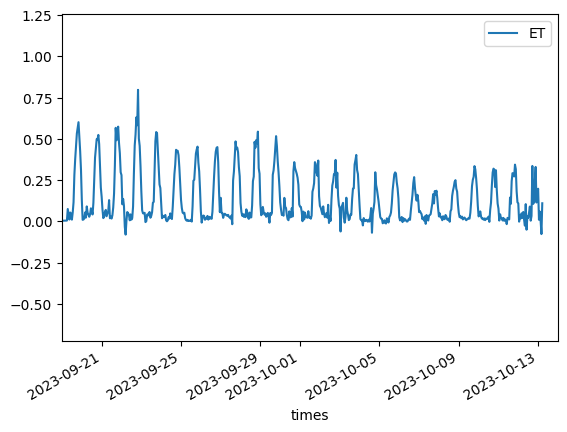

In [101]:
for xlim in xlim_list:
    daily_flux.plot(x='times',y='ET',xlim=xlim)

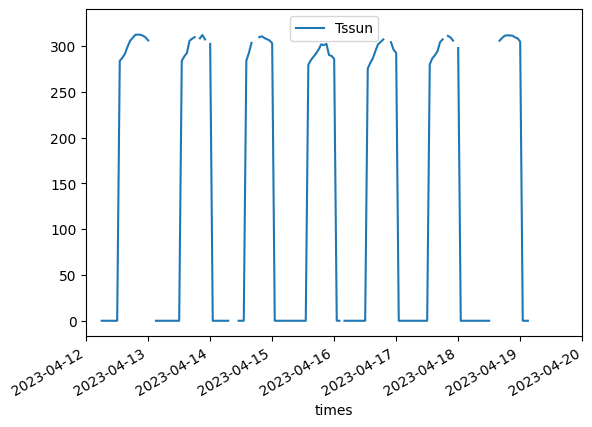

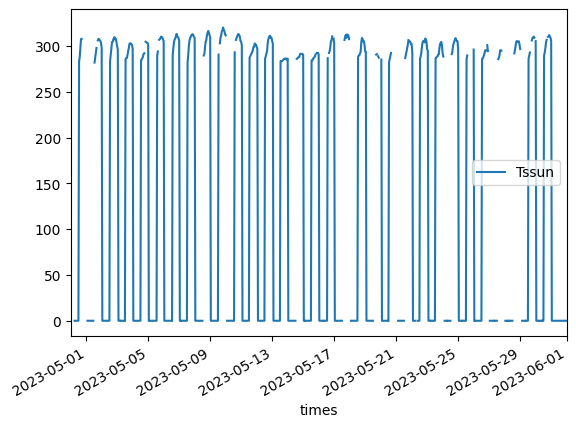

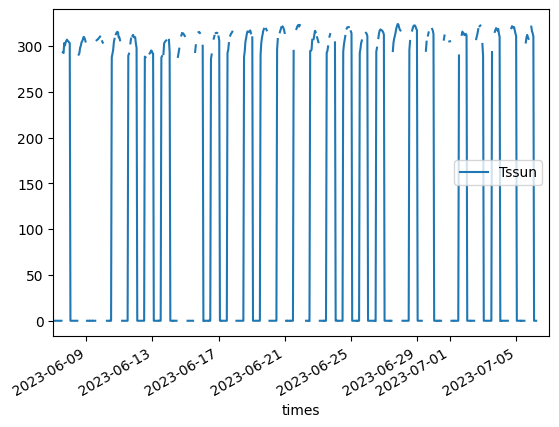

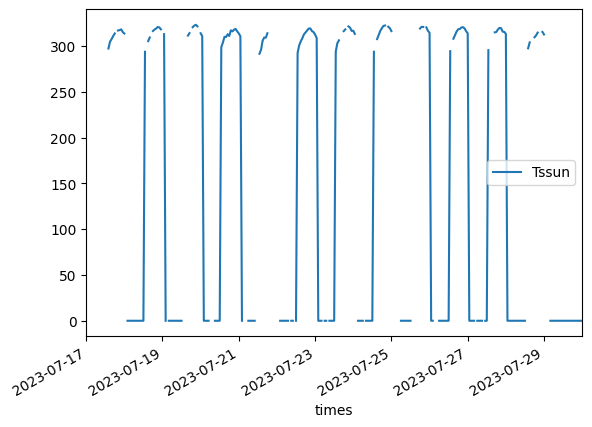

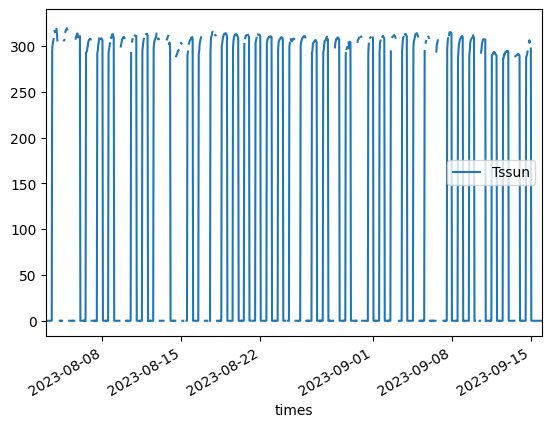

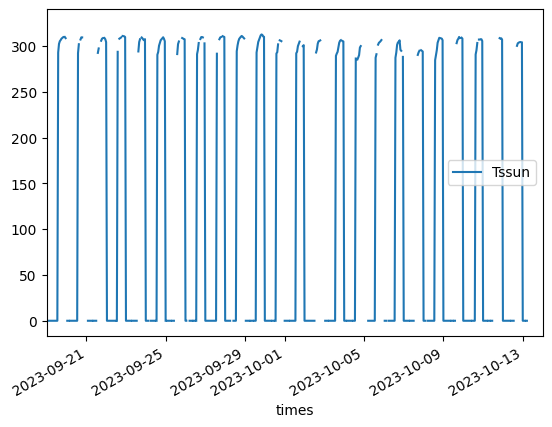

In [102]:
for xlim in xlim_list:
    daily_flux.plot(x='times',y='Tssun',xlim=xlim)

In [103]:
#interpolate nan
for i in inputs:
    if 'T' in i:
        daily_flux.loc[:,i]=daily_flux[i].interpolate(method='linear')

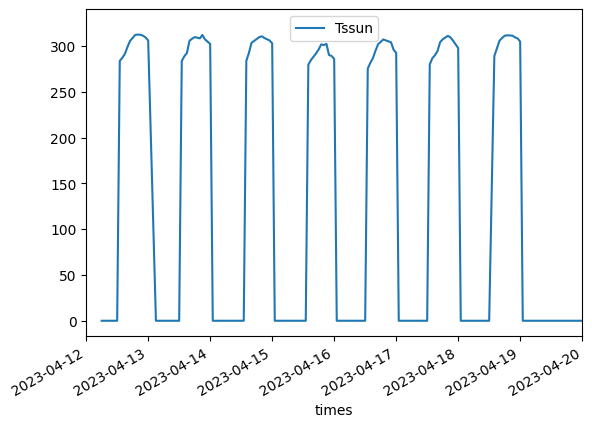

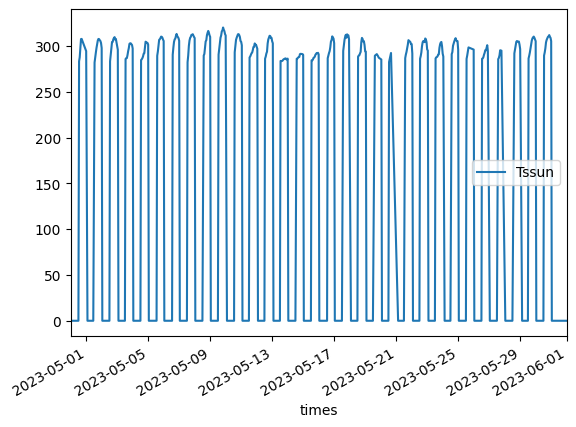

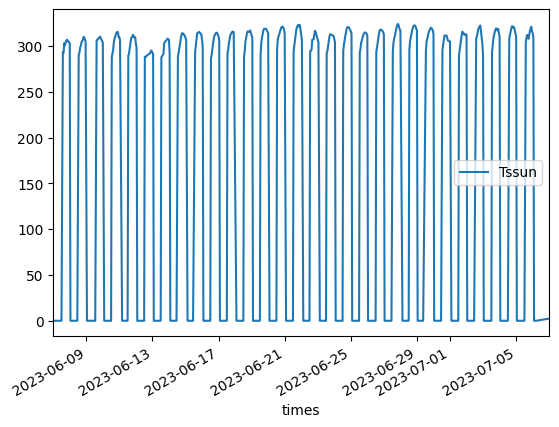

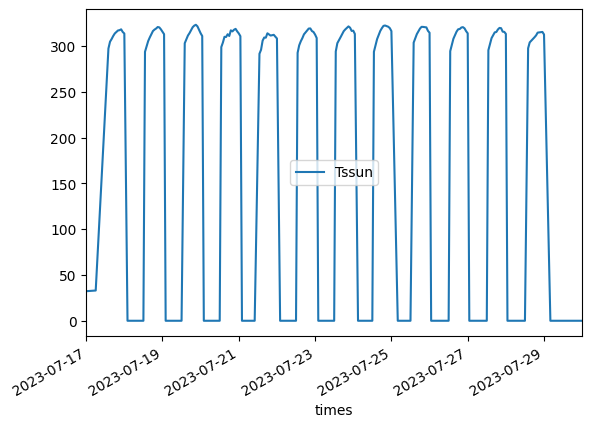

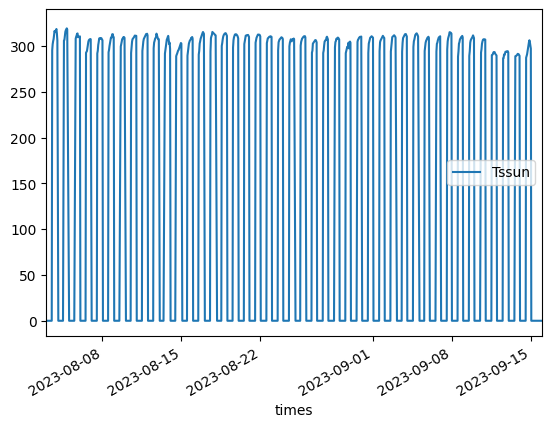

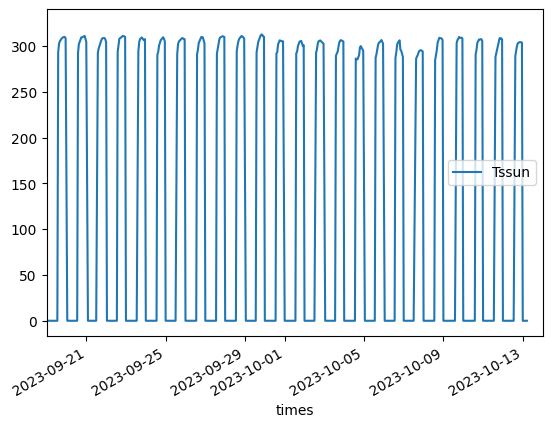

In [104]:
for xlim in xlim_list:
    daily_flux.plot(x='times',y='Tssun',xlim=xlim)

In [105]:
daily_flux.to_csv('../../work/CookIRCamET/Working/cprlhy2023_batches_processed.csv', index=False)